In [1]:
import pandas as pd
import numpy as np

import string
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel



In [2]:
pd.options.display.max_colwidth = 200

In [3]:
df = pd.read_csv('anxiety_tweets.csv')

In [4]:
df.tail(20)

,text,user,date,retweet,mention,hashtags,location
9980,Good news... survived #RootCanal.... bad news .... I still suffer from #anxiety and passed out afterwards #FridayThoughts,Miguel1979,2019-11-22 16:35:13+00:00,0,NaN,#RootCanal #anxiety #FridayThoughts,NaN
9981,My anxiety is fucking with me at work I feel like shit,__wzrd__,2019-11-22 16:21:12+00:00,0,NaN,NaN,NaN
9982,love when my body is too physically exhausted to feel anxiety,dakotajamess,2019-11-22 16:11:03+00:00,0,NaN,NaN,NaN
9983,My anxiety is on 100 today,Mckennacm__,2019-11-22 15:16:00+00:00,0,NaN,NaN,NaN
9984,I’m on vacation for the next ten days and I’m actually having anxiety about the long to do list I made. I’m now also in the nesting phase of pregnancy so on the top of the list is cleaning the clo...,RovikaRajkishun,2019-11-22 14:48:05+00:00,0,NaN,NaN,NaN
9985,Jesus...I haven't been this nervous in ages....#Dentist #anxiety #stress #FridayMorning ....,Miguel1979,2019-11-22 14:29:40+00:00,0,NaN,#Dentist #anxiety #stress #FridayMorning,NaN
9986,This how you know the social anxiety is real. She said fuck it imma just clean nigguhs houses.,Stushkaiser,2019-11-22 12:38:10+00:00,0,NaN,NaN,NaN
9987,And this is coming from someone who is just naturally awkward and has had social anxiety since childhood. Plenty of people find me hilarious and I’m sure a good amount find me obnoxious and and un...,_HanSoto,2019-11-22 12:31:47+00:00,0,NaN,NaN,NaN
9988,"Y’all don’t know what social anxiety means, however this video weird as hell",NicksealeHQ,2019-11-22 12:25:01+00:00,0,NaN,NaN,NaN
9989,Omg if it wasn’t for @survivorcbs and @CBSBigBrother my entire commute from NYC - PHIL would be such a nightmare. Especially Survivor! Thank you for helping me survive through my anxiety during my...,Cami_Crew,2019-11-22 10:56:05+00:00,0,@survivorcbs @CBSBigBrother,NaN,NaN


In [15]:
stop_words = stopwords.words('english')

#add punctuation char's to stopwords list
stop_words += list(string.punctuation)
stop_words += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'anxiety','feel', 'give', 'giving', 'help', 'said', 'also', 'rt']

In [13]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [14]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [36]:
def remove_urls(text_col):
    text_col = text_col.str.replace(r"http\S+", "")

remove_urls(df['text'])

In [23]:
random_sentence = ['Heres is a random sentence to test']
new = []
for items in random_sentence:
    new.append(items.split())

In [38]:
def tokenize_lowercase(text):
    tokens = word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

In [39]:
df['text'] = df['text'].apply(process_text)

In [40]:
df['text'].head()

0    [okay, totally, understand, specific, struggle...
1    [things, know, returning, hair, salon, excitem...
2    [well, information, would, useful, months, avo...
3                                   [greatest, lately]
4    [mostly, afraid, really, misunderstandings, pa...
Name: text, dtype: object

In [11]:
lemmatizer = WordNetLemmatizer()

lemmatizer.lemmatize('giving')

'giving'

In [41]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(df_text):
    lemmatized =[]
    for w in df_text:
        lemmatized.append(lemmatizer.lemmatize(w))
    return lemmatized

In [42]:
df['text'] = df['text'].apply(lemmatize_text)

In [70]:
df

,text,user,date,retweet,mention,hashtags,location
0,"[okay, totally, understand, specific, struggle, queer, japanese, japanese, people, open, learning, feel, personally, mean, exist, applies, racism,...",wakuu,2020-06-08 23:58:16+00:00,1,NaN,NaN,NaN
1,"[thing, know, returning, hair, salon, excitement, normal, salon, barber, shop, long, island, enters, phase, phase2]",cbiz,2020-06-08 23:58:01+00:00,0,NaN,#phase2,NaN
2,"[well, information, would, useful, month, avoided, wasted, every, single, time, person, came, even, slightly, close, entering, general, vicinity]",SKastenbaum,2020-06-08 23:50:47+00:00,0,NaN,NaN,NaN
3,"[greatest, lately]",xI_am_Carolinex,2020-06-08 23:49:55+00:00,0,NaN,NaN,NaN
4,"[mostly, afraid, really, misunderstanding, past, kept, recently, reached, point, desperation, something, surprisingly, attentive, validating, glad...",darshanaheena,2020-06-08 23:48:03+00:00,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
9995,"[finished, season, know, give, make, never, want, speak]",mmmeghan,2019-11-22 02:19:36+00:00,0,NaN,NaN,NaN
9996,"[serious, note, hate, people, joke, laugh, rush, like, really, actually, bother, please]",justlikestephxx,2019-11-22 02:05:33+00:00,0,NaN,NaN,NaN
9997,"[think, attach, like, shaking, feeling, feel, limp]",momozelly,2019-11-22 02:04:16+00:00,0,NaN,NaN,NaN
9998,"[tryna, deal, depression, netflix, apple, music, bill]",smittty_93,2019-11-22 01:58:51+00:00,0,NaN,NaN,NaN


In [83]:
for items in df['text']:
    for text in items:
        if '*' in text:
            print(text)

*raises
hand*
*president
*better*
*not*
around*
*sigh*
*me*
*not*
*and*
ba*d
*verify*
*has*
*anxiety
*dread
*worry
juice*
*coffee
*anxiety
love*
*and*
*alllll
this*
***gestures
around***
*gets
protesting*
*considers
going*
*gets
*relatively*
*anxiety
*emotional
*means
*avoiding
*situations
*trigger
*deep
breaths*
*black*
dr*g
sh*tless
*after*
*ought*
*something
*anxiety
chat*
*thing*
*dies*
*having
anxiety*
*can
*anxiety
*jeff
voice*
*sigh*
life*
*regardless
*instant
activated*
possible*
later**
*only*
*bites
*not*
*terrible*
*exists*
*but
*spongebob
voice*
tr*mp
*pinch*
m*sic
*lot*
*hits
*panic
anxiety*
l***d***
*clears
throat*
*hasn
medicine*
*average
day*
*overwhelming
*everything*
*sigh*
*smacks
button*
*trying*
b*tch
*feels
discomfort*
*momentarily
covid*
*remembers
manifestations*
*nose*
*shrugs*
distinctly*
*can
anxiety*
*drinks
coffee*
*increases*
*watches
uncaged*
f***ing
sh*t
**chewing**
*hands
anxiety*
*vibing*
*trying
whatsoever*
*deep
breathes*
*is*
*blacks
anxiety*
said*


In [44]:
all_words = [word for tokens in df['text'] for word in tokens]
tweet_lengths = [len(tokens) for tokens in df['text']]
vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

104839 words total, with a vocabulary size of 15878
Max tweet length is 32


In [45]:
text_dict = Dictionary(df.text)

In [82]:
text_dict.save_as_text('tweet_text_dict.txt')

In [46]:
tweets_corpus = [text_dict.doc2bow(tweet) for tweet in df['text']]

In [73]:
tweets_corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1)],
 [(19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 2),
  (31, 1),
  (32, 1)],
 [(33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1)],
 [(51, 1), (52, 1)],
 [(53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1)],
 [(45, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1)],
 [(74, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1)],
 [(50, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89

In [52]:
# compute coherence
tweets_coherence = []
for nb_topics in range(1,36):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = text_dict, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary= text_dict, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

# # visualize coherence
# plt.figure(figsize=(10,5))
# plt.plot(range(1,36),tweets_coherence)
# plt.xlabel("Number of Topics")
# plt.ylabel("Coherence Score");

KeyboardInterrupt: 

In [48]:
k = 6
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = text_dict, passes=10)

In [ ]:
'feel', 'give', 'help', 'said', 'also'

In [51]:
tweets_lda.show_topics()

[(0,
  '0.006*"gave" + 0.006*"fear" + 0.005*"trump" + 0.005*"help" + 0.005*"people" + 0.004*"economic" + 0.004*"great" + 0.004*"covid-19" + 0.004*"also" + 0.004*"said"'),
 (1,
  '0.011*"like" + 0.011*"today" + 0.009*"going" + 0.009*"good" + 0.008*"help" + 0.008*"stress" + 0.008*"much" + 0.007*"really" + 0.007*"time" + 0.007*"feel"'),
 (2,
  '0.010*"give" + 0.008*"coronavirus" + 0.008*"depression" + 0.008*"shit" + 0.006*"people" + 0.005*"stress" + 0.005*"attack" + 0.005*"worst" + 0.005*"help" + 0.005*"night"'),
 (3,
  '0.017*"like" + 0.016*"people" + 0.014*"time" + 0.012*"much" + 0.010*"depression" + 0.009*"feel" + 0.008*"give" + 0.008*"know" + 0.007*"make" + 0.006*"love"'),
 (4,
  '0.010*"attack" + 0.009*"like" + 0.008*"roof" + 0.007*"work" + 0.006*"time" + 0.005*"feel" + 0.005*"today" + 0.004*"really" + 0.004*"thru" + 0.004*"hand"'),
 (5,
  '0.016*"giving" + 0.008*"social" + 0.008*"hate" + 0.006*"sleep" + 0.006*"today" + 0.006*"relief" + 0.005*"pain" + 0.004*"song" + 0.004*"give" + 0.

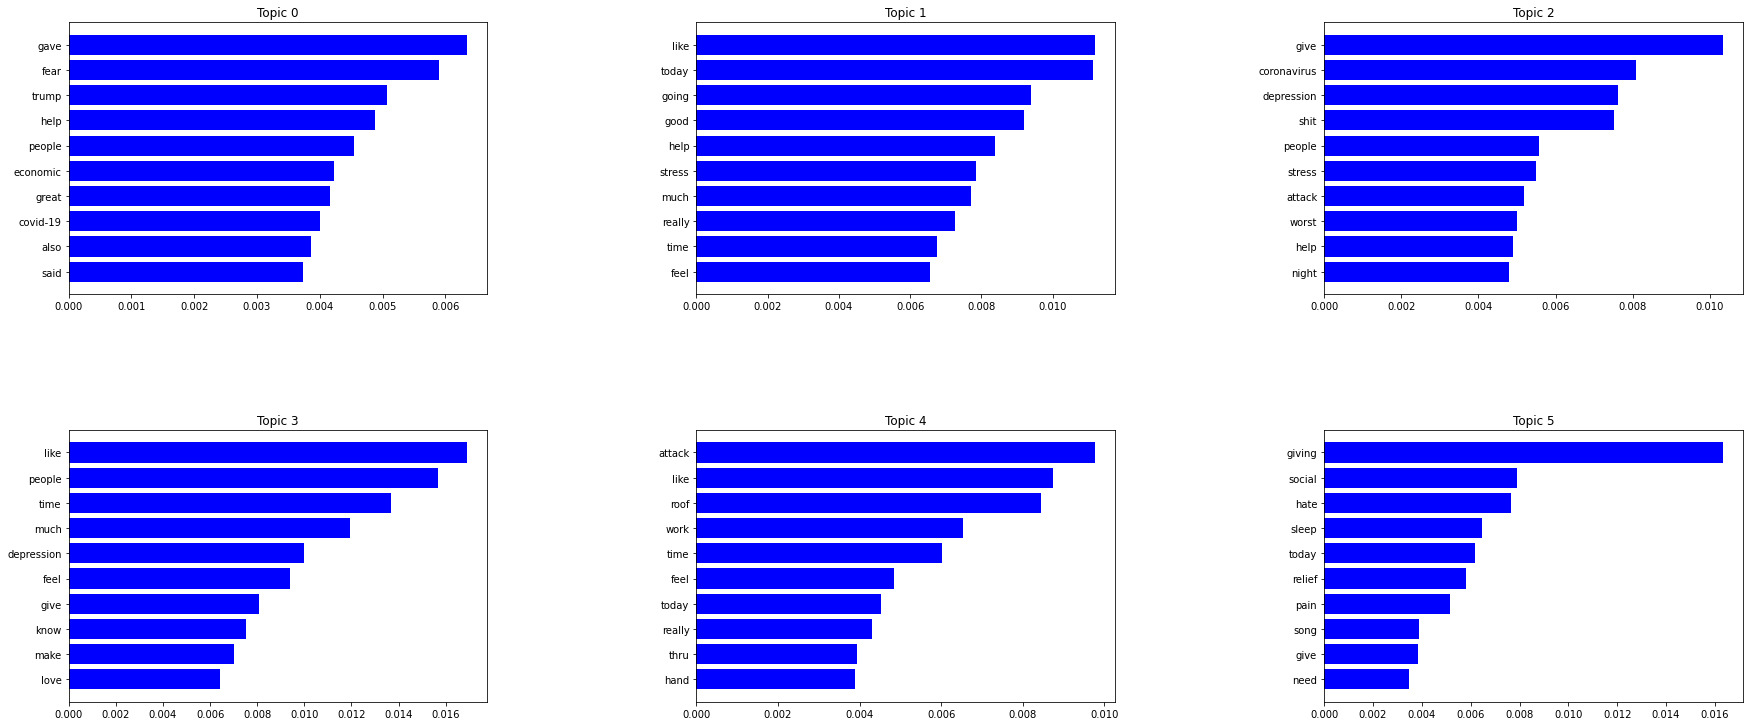

In [65]:
def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=.5, hspace=.5)
    plt.figure(figsize=(30,20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
plot_top_words()

In [84]:
df.iloc[9973]


text        [painting, batman, procreate, pocket, color, paint, iphone, finger, mark, stroke, brush, manhattan, york]
user                                                                                                        jmignault
date                                                                                        2019-11-22 22:07:49+00:00
retweet                                                                                                             0
mention                                                                                                    @Procreate
hashtags                   #painting #anxiety #batman #pocket #art #color #paint #iphone #finger #mark #stroke #brush
location                                                                                                          NaN
Name: 9973, dtype: object